In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

In [2]:
batting_df = pd.read_pickle('./FinalDFs/PostEDA/batting_df.pkl')
bowling_df = pd.read_pickle('./FinalDFs/PostEDA/bowling_df.pkl')

# **Part 1: Data Preprocessing**

In [59]:
batting_filtered = batting_df.copy()
bowling_filtered = bowling_df.copy()

## **(I) Scaling the Numeric Columns**

The next step is to scale the numeric columns using the `StandardScaler`.

In [60]:
batting_scaler = StandardScaler()
bowling_scaler = StandardScaler()

bat_num_cols = [col for col in batting_filtered.select_dtypes(include=[np.number]).columns if col not in ['Season', 'Role', 'changed_teams']]
bowl_num_cols = [col for col in bowling_filtered.select_dtypes(include=[np.number]).columns if col not in ['Season', 'Role', 'changed_teams']]

In [61]:
batting_filtered[bat_num_cols] = batting_scaler.fit_transform(batting_filtered[bat_num_cols])
bowling_filtered[bowl_num_cols] = bowling_scaler.fit_transform(bowling_filtered[bowl_num_cols])

In [62]:
batting_scaler_filepath = './model metrics/trained_batting_scaler.pkl'
with open(batting_scaler_filepath, 'wb') as f:
    pickle.dump(batting_scaler, f)

In [63]:
bowling_scaler_filepath = './model metrics/trained_bowling_scaler.pkl'
with open(bowling_scaler_filepath, 'wb') as f:
    pickle.dump(bowling_scaler, f)

## **(II) Getting Dummies for the Categorical Columns**

The final step in data preprocessing is getting dummies for the categorical columns.

In [8]:
batting_filtered = pd.get_dummies(batting_filtered, columns=['Country', 'Team'])

In [9]:
bowling_filtered = pd.get_dummies(bowling_filtered, columns=['Country', 'Team'])

# **Part 2: Train-Test Split**

In [10]:
batting_filtered = batting_filtered.sort_values(by='Season')
bowling_filtered = bowling_filtered.sort_values(by='Season')

In [11]:
batting_train, batting_test = train_test_split(batting_filtered, test_size=.2)
bowling_train, bowling_test = train_test_split(bowling_filtered, test_size=.2)

In [12]:
X_train_bat = batting_train.drop(columns=['Player', 'NY_SalaryUSD'])
y_train_bat = batting_train['NY_SalaryUSD']

X_test_bat = batting_test.drop(columns=['Player', 'NY_SalaryUSD'])
y_test_bat = batting_test['NY_SalaryUSD']

In [13]:
X_train_bowl = bowling_train.drop(columns=['Player', 'NY_SalaryUSD'])
y_train_bowl = bowling_train['NY_SalaryUSD']

X_test_bowl = bowling_test.drop(columns=['Player', 'NY_SalaryUSD'])
y_test_bowl = bowling_test['NY_SalaryUSD']

# **Part 3: Batting Models**

In [14]:
mean_target = y_train_bat.mean()

y_pred_mean = np.full(y_test_bat.shape, mean_target)

mae_mean = mean_absolute_error(y_test_bat, y_pred_mean)
mse_mean = mean_squared_error(y_test_bat, y_pred_mean)
r2_mean = r2_score(y_test_bat, y_pred_mean)

print("Mean-Based Model:")
print("MAE:", mae_mean)
print("MSE:", mse_mean)
print("R^2:", r2_mean)

Mean-Based Model:
MAE: 0.7911927399193965
MSE: 0.9934591239359714
R^2: -3.448349828127917e-05


## (I) Linear Models

In [15]:
linear_model = LinearRegression()
linear_model.fit(X_train_bat, y_train_bat)
y_pred_linear = linear_model.predict(X_test_bat)

mae_linear = mean_absolute_error(y_test_bat, y_pred_linear)
mse_linear = mean_squared_error(y_test_bat, y_pred_linear)
r2_linear = r2_score(y_test_bat, y_pred_linear)

print("\nLinear Regression Model:")
print("MAE:", mae_linear)
print("MSE:", mse_linear)
print("R^2:", r2_linear)


Linear Regression Model:
MAE: 0.34899408303953905
MSE: 0.27033313691888483
R^2: 0.727877622302082


In [16]:
constant_feature_mask = X_train_bat.apply(lambda col: col.nunique() != 1)
X_train_bat = X_train_bat.loc[:, constant_feature_mask]
X_test_bat = X_test_bat.loc[:, constant_feature_mask]

In [17]:
k=10
selector = SelectKBest(score_func=f_regression, k=k)

X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
X_test_bat_selected = selector.transform(X_test_bat)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_bat.columns[selected_feature_indices]

In [18]:
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_bat_selected, y_train_bat)
y_pred_linear_selected = linear_model_selected.predict(X_test_bat_selected)

mae_linear_selected = mean_absolute_error(y_test_bat, y_pred_linear_selected)
mse_linear_selected = mean_squared_error(y_test_bat, y_pred_linear_selected)
r2_linear_selected = r2_score(y_test_bat, y_pred_linear_selected)

print("\nLinear Regression Model with Selected Features:")
print("Selected Features:", selected_feature_names)
print("MAE:", mae_linear_selected)
print("MSE:", mse_linear_selected)
print("R^2:", r2_linear_selected)


Linear Regression Model with Selected Features:
Selected Features: Index(['SalaryUSD', 'MatchCount', 'SeasonCount', 'balls_faced', 'total_runs',
       'batting_avg', '50s', '4s', '6s', 'Country_Uncapped'],
      dtype='object')
MAE: 0.3459922538918167
MSE: 0.2646939789605571
R^2: 0.7335541038807896


In [19]:
k_values = range(1, 11)

linear_mae_scores = []
elastic_net_mae_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
    X_test_bat_selected = selector.transform(X_test_bat)

    linear_model_selected = LinearRegression()
    linear_model_selected.fit(X_train_bat_selected, y_train_bat)
    y_pred_linear_selected = linear_model_selected.predict(X_test_bat_selected)
    mae_linear = mean_absolute_error(y_test_bat, y_pred_linear_selected)
    linear_mae_scores.append(mae_linear)

    # ElasticNet Regression
    elastic_net_model = ElasticNet()
    elastic_net_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_elastic_net_selected = elastic_net_model.predict(X_test_bat_selected)
    elastic_net_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_elastic_net_selected))

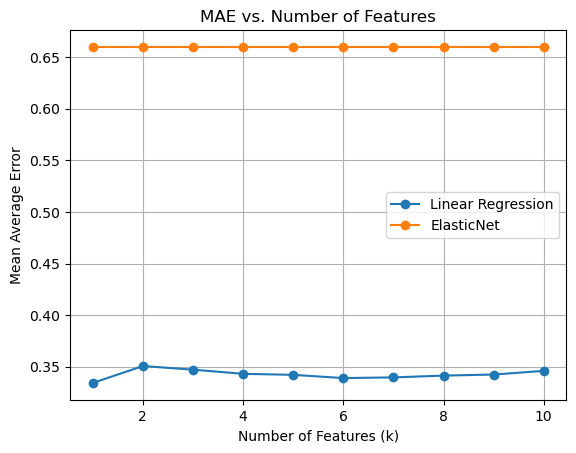

In [20]:
plt.plot(k_values, linear_mae_scores, label='Linear Regression', marker='o')
plt.plot(k_values, elastic_net_mae_scores, label='ElasticNet', marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean Average Error')
plt.title('MAE vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

## (II) Other Models

In [21]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_bat, y_train_bat)
y_pred_rf = rf_model.predict(X_test_bat)

mae_rf = mean_absolute_error(y_test_bat, y_pred_rf)
mse_rf = mean_squared_error(y_test_bat, y_pred_rf)
r2_rf = r2_score(y_test_bat, y_pred_rf)

print("\nRandom Forest Regression Model:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("R^2:", r2_rf)


Random Forest Regression Model:
MAE: 0.3560642134655057
MSE: 0.3159333954324469
R^2: 0.6819755515763848


In [22]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train_bat, y_train_bat)
y_pred_gb = gb_model.predict(X_test_bat)

mae_gb = mean_absolute_error(y_test_bat, y_pred_gb)
mse_gb = mean_squared_error(y_test_bat, y_pred_gb)
r2_gb = r2_score(y_test_bat, y_pred_gb)

print("\nGradient Boosting Regression Model:")
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("R^2:", r2_gb)


Gradient Boosting Regression Model:
MAE: 0.3702087536093447
MSE: 0.3278603549034046
R^2: 0.6699696517191372


In [23]:
sv_model = SVR()
sv_model.fit(X_train_bat, y_train_bat)
y_pred_sv = sv_model.predict(X_test_bat)

mae_sv = mean_absolute_error(y_test_bat, y_pred_sv)
mse_sv = mean_squared_error(y_test_bat, y_pred_sv)
r2_sv = r2_score(y_test_bat, y_pred_sv)

print("\nSupport Vector Regression Model:")
print("MAE:", mae_sv)
print("MSE:", mse_sv)
print("R^2:", r2_sv)


Support Vector Regression Model:
MAE: 0.7496499620331889
MSE: 1.0651856539753803
R^2: -0.0722357464318808


In [24]:
k_values = range(1, 11)
random_forest_mae_scores = []
gradient_boosting_mae_scores = []
svm_mae_scores = []
knn_mae_scores = []
xgboost_mae_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bat_selected = selector.fit_transform(X_train_bat, y_train_bat)
    X_test_bat_selected = selector.transform(X_test_bat)

    # Random Forest Regression
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_rf_selected = rf_model.predict(X_test_bat_selected)
    random_forest_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_rf_selected))

    # Gradient Boosting Regression
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_gb_selected = gb_model.predict(X_test_bat_selected)
    gradient_boosting_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_gb_selected))

    # Support Vector Regression (SVR)
    svr_model = SVR()
    svr_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_svr_selected = svr_model.predict(X_test_bat_selected)
    svm_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_svr_selected))

    # K-Nearest Neighbors Regression
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_knn_selected = knn_model.predict(X_test_bat_selected)
    knn_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_knn_selected))

    # XGBoost Regression
    xgboost_model = xgb.XGBRegressor()
    xgboost_model.fit(X_train_bat_selected, y_train_bat)
    y_pred_xgboost_selected = xgboost_model.predict(X_test_bat_selected)
    xgboost_mae_scores.append(mean_absolute_error(y_test_bat, y_pred_xgboost_selected))

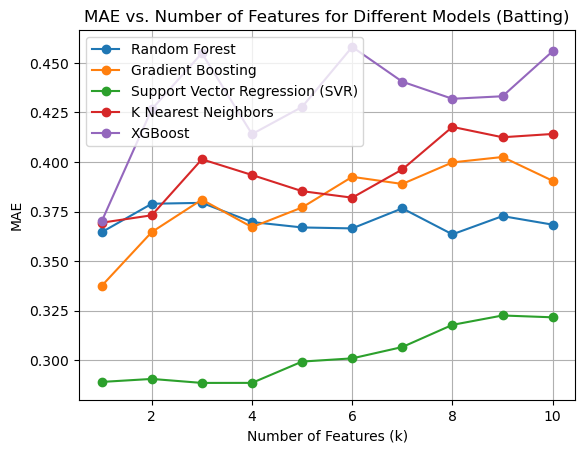

In [25]:
plt.plot(k_values, random_forest_mae_scores, label='Random Forest', marker='o')
plt.plot(k_values, gradient_boosting_mae_scores, label='Gradient Boosting', marker='o')
plt.plot(k_values, svm_mae_scores, label='Support Vector Regression (SVR)', marker='o')
plt.plot(k_values, knn_mae_scores, label='K Nearest Neighbors', marker='o')
plt.plot(k_values, xgboost_mae_scores, label='XGBoost', marker='o')

plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.title('MAE vs. Number of Features for Different Models (Batting)')
plt.legend()
plt.grid(True)
plt.show()


## (III) Weak Time Series Cross Validation of Models

In [26]:
def time_validate_mae(validation_model, data):

    model = validation_model
    mae_dict = {}
    
    for year in range(2009, 2020):
        X_train = data[data['Season'] < year].drop(columns=['Player', 'NY_SalaryUSD'])
        y_train = data[data['Season'] < year]['NY_SalaryUSD']
        X_test = data[data['Season'] == year].drop(columns=['Player', 'NY_SalaryUSD'])
        y_test = data[data['Season'] == year]['NY_SalaryUSD']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae_dict[year] = mean_absolute_error(y_test, y_pred)

    return mae_dict

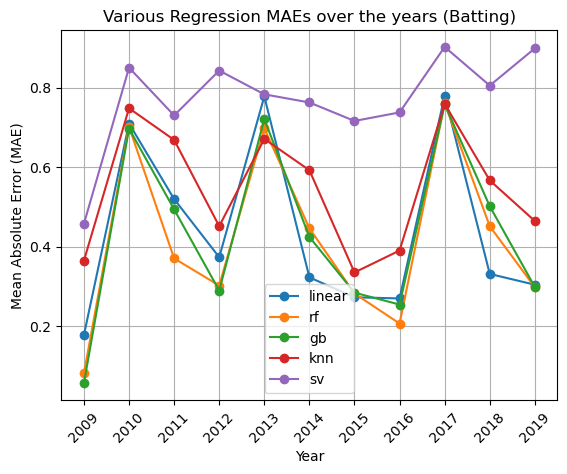

In [27]:
regression_model_dict = {
    'linear': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'sv': SVR()
}
for model_name, model_func in regression_model_dict.items():
    mae = time_validate_mae(model_func, batting_filtered)
    plt.plot(list(mae.keys()), list(mae.values()), marker='o', label = model_name)

plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Various Regression MAEs over the years (Batting)')
plt.legend()
plt.grid(True)
plt.xticks(list(mae.keys()), rotation=45)
plt.show()

# **Part 4: Bowling Models**

In [28]:
mean_target = y_train_bowl.mean()

y_pred_mean = np.full(y_test_bowl.shape, mean_target)

mae_mean = mean_absolute_error(y_test_bowl, y_pred_mean)
mse_mean = mean_squared_error(y_test_bowl, y_pred_mean)
r2_mean = r2_score(y_test_bowl, y_pred_mean)

print("Mean-Based Model:")
print("MAE:", mae_mean)
print("MSE:", mse_mean)
print("R^2:", r2_mean)

Mean-Based Model:
MAE: 0.8062093558877261
MSE: 1.0185367123985123
R^2: -0.001857020025512135


## (I) Linear Models

In [29]:
linear_model = LinearRegression()
linear_model.fit(X_train_bowl, y_train_bowl)
y_pred_linear = linear_model.predict(X_test_bowl)

mae_linear = mean_absolute_error(y_test_bowl, y_pred_linear)
mse_linear = mean_squared_error(y_test_bowl, y_pred_linear)
r2_linear = r2_score(y_test_bowl, y_pred_linear)

print("\nLinear Regression Model:")
print("MAE:", mae_linear)
print("MSE:", mse_linear)
print("R^2:", r2_linear)


Linear Regression Model:
MAE: 0.4063847606546788
MSE: 0.3352137303408906
R^2: 0.6702757741936345


In [30]:
constant_feature_mask = X_train_bowl.apply(lambda col: col.nunique() != 1)
X_train_bowl = X_train_bowl.loc[:, constant_feature_mask]
X_test_bowl = X_test_bowl.loc[:, constant_feature_mask]

In [31]:
k=10
selector = SelectKBest(score_func=f_regression, k=k)

X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
X_test_bowl_selected = selector.transform(X_test_bowl)

selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_train_bowl.columns[selected_feature_indices]

In [32]:
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_bowl_selected, y_train_bowl)
y_pred_linear_selected = linear_model_selected.predict(X_test_bowl_selected)

mae_linear_selected = mean_absolute_error(y_test_bowl, y_pred_linear_selected)
mse_linear_selected = mean_squared_error(y_test_bowl, y_pred_linear_selected)
r2_linear_selected = r2_score(y_test_bowl, y_pred_linear_selected)

print("\nLinear Regression Model with Selected Features:")
print("Selected Features:", selected_feature_names)
print("MAE:", mae_linear_selected)
print("MSE:", mse_linear_selected)
print("R^2:", r2_linear_selected)


Linear Regression Model with Selected Features:
Selected Features: Index(['Role', 'SalaryUSD', 'MatchCount', 'balls_bowled', 'total_runs',
       'total_wickets', 'dots', '4s', '6s', 'Country_Uncapped'],
      dtype='object')
MAE: 0.41093196300473134
MSE: 0.3376324799299523
R^2: 0.6678966343688373


In [33]:
k_values = range(1, 11)

linear_mae_scores = []
elastic_net_mae_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
    X_test_bowl_selected = selector.transform(X_test_bowl)

    linear_model_selected = LinearRegression()
    linear_model_selected.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_linear_selected = linear_model_selected.predict(X_test_bowl_selected)
    mae_linear = mean_absolute_error(y_test_bowl, y_pred_linear_selected)
    linear_mae_scores.append(mae_linear)

    # ElasticNet Regression
    elastic_net_model = ElasticNet()
    elastic_net_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_elastic_net_selected = elastic_net_model.predict(X_test_bowl_selected)
    elastic_net_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_elastic_net_selected))

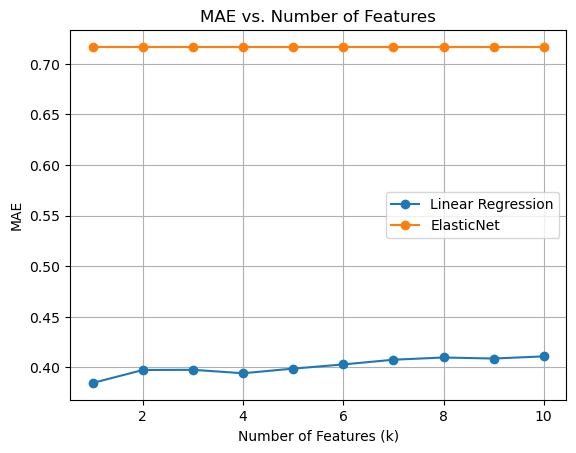

In [34]:
plt.plot(k_values, linear_mae_scores, label='Linear Regression', marker='o')
plt.plot(k_values, elastic_net_mae_scores, label='ElasticNet', marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.title('MAE vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

## (II) Other Models

In [35]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train_bowl, y_train_bowl)
y_pred_rf = rf_model.predict(X_test_bowl)

mae_rf = mean_absolute_error(y_test_bowl, y_pred_rf)
mse_rf = mean_squared_error(y_test_bowl, y_pred_rf)
r2_rf = r2_score(y_test_bowl, y_pred_rf)

print("\nRandom Forest Regression Model:")
print("MAE:", mae_rf)
print("MSE:", mse_rf)
print("R^2:", r2_rf)


Random Forest Regression Model:
MAE: 0.405620636817437
MSE: 0.38056741477299844
R^2: 0.6256648077167078


In [36]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train_bowl, y_train_bowl)
y_pred_gb = gb_model.predict(X_test_bowl)

mae_gb = mean_absolute_error(y_test_bowl, y_pred_gb)
mse_gb = mean_squared_error(y_test_bowl, y_pred_gb)
r2_gb = r2_score(y_test_bowl, y_pred_gb)

print("\nGradient Boosting Regression Model:")
print("MAE:", mae_gb)
print("MSE:", mse_gb)
print("R^2:", r2_gb)


Gradient Boosting Regression Model:
MAE: 0.4329287681868219
MSE: 0.3875720167843821
R^2: 0.6187749139974486


In [37]:
sv_model = SVR()
sv_model.fit(X_train_bowl, y_train_bowl)
y_pred_sv = sv_model.predict(X_test_bowl)

mae_sv = mean_absolute_error(y_test_bowl, y_pred_sv)
mse_sv = mean_squared_error(y_test_bowl, y_pred_sv)
r2_sv = r2_score(y_test_bowl, y_pred_sv)

print("\nSupport Vector Regression Model:")
print("MAE:", mae_sv)
print("MSE:", mse_sv)
print("R^2:", r2_sv)


Support Vector Regression Model:
MAE: 0.7798483494100377
MSE: 1.0882699269497127
R^2: -0.07044827420087563


In [38]:
k_values = range(1, 11)
random_forest_mae_scores = []
gradient_boosting_mae_scores = []
svm_mae_scores = []
knn_mae_scores = []
xgboost_mae_scores = []

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_bowl_selected = selector.fit_transform(X_train_bowl, y_train_bowl)
    X_test_bowl_selected = selector.transform(X_test_bowl)

    # Random Forest Regression
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_rf_selected = rf_model.predict(X_test_bowl_selected)
    random_forest_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_rf_selected))

    # Gradient Boosting Regression
    gb_model = GradientBoostingRegressor()
    gb_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_gb_selected = gb_model.predict(X_test_bowl_selected)
    gradient_boosting_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_gb_selected))

    # Support Vector Regression (SVR)
    svr_model = SVR()
    svr_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_svr_selected = svr_model.predict(X_test_bowl_selected)
    svm_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_svr_selected))

    # K-Nearest Neighbors Regression
    knn_model = KNeighborsRegressor()
    knn_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_knn_selected = knn_model.predict(X_test_bowl_selected)
    knn_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_knn_selected))

    # XGBoost Regression
    xgboost_model = xgb.XGBRegressor()
    xgboost_model.fit(X_train_bowl_selected, y_train_bowl)
    y_pred_xgboost_selected = xgboost_model.predict(X_test_bowl_selected)
    xgboost_mae_scores.append(mean_absolute_error(y_test_bowl, y_pred_xgboost_selected))

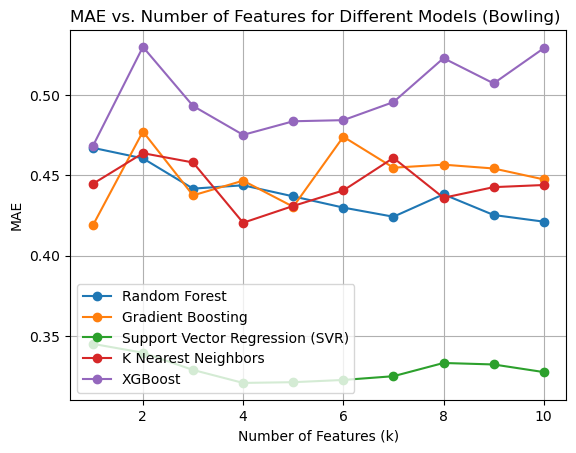

In [39]:
plt.plot(k_values, random_forest_mae_scores, label='Random Forest', marker='o')
plt.plot(k_values, gradient_boosting_mae_scores, label='Gradient Boosting', marker='o')
plt.plot(k_values, svm_mae_scores, label='Support Vector Regression (SVR)', marker='o')
plt.plot(k_values, knn_mae_scores, label='K Nearest Neighbors', marker='o')
plt.plot(k_values, xgboost_mae_scores, label='XGBoost', marker='o')

plt.xlabel('Number of Features (k)')
plt.ylabel('MAE')
plt.title('MAE vs. Number of Features for Different Models (Bowling) ')
plt.legend()
plt.grid(True)
plt.show()


## (III) Weak Time Series Cross Validation of Models

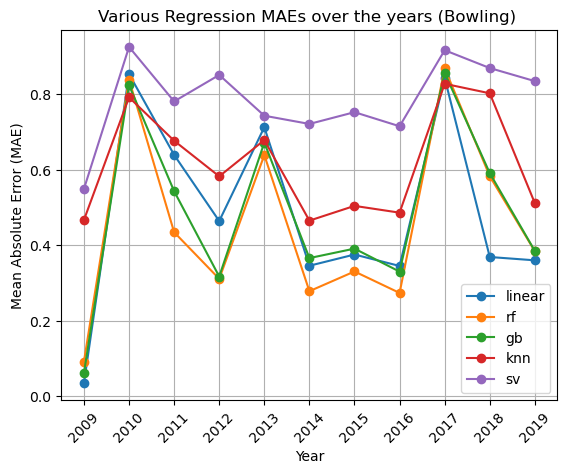

In [40]:
regression_model_dict = {
    'linear': LinearRegression(),
    'rf': RandomForestRegressor(),
    'gb': GradientBoostingRegressor(),
    'knn': KNeighborsRegressor(),
    'sv': SVR()
}
for model_name, model_func in regression_model_dict.items():
    mae = time_validate_mae(model_func, bowling_filtered)
    plt.plot(list(mae.keys()), list(mae.values()), marker='o', label = model_name)

plt.xlabel('Year')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Various Regression MAEs over the years (Bowling) ')
plt.legend()
plt.grid(True)
plt.xticks(list(mae.keys()), rotation=45)
plt.show()

# **Part 5: Hyperparameter Tuning**

## (I) Batting Model

In [47]:
bat_selector = SelectKBest(score_func=f_regression, k=4)
X_train_bat_selected = bat_selector.fit_transform(X_train_bat, y_train_bat)
X_test_bat_selected = bat_selector.transform(X_test_bat)

In [48]:
param_grid_svr = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'epsilon': [0.01, 0.1],     # Epsilon parameter in the epsilon-insensitive loss function
    'kernel': ['linear', 'rbf'] # Kernel type for SVR
}

bat_svr_model = SVR()
batting_grid_search = GridSearchCV(bat_svr_model, param_grid_svr, scoring='neg_mean_absolute_error', cv=5)
batting_grid_search.fit(X_train_bat_selected, y_train_bat)
best_svr_model_bat = batting_grid_search.best_estimator_

In [49]:
best_params = batting_grid_search.best_params_
best_svr_model_bat = batting_grid_search.best_estimator_
y_pred_svr_tuned = best_svr_model_bat.predict(X_test_bat_selected)
r2_svr_tuned = r2_score(y_test_bat, y_pred_svr_tuned)
mae_svr_tuned = mean_absolute_error(y_test_bat, y_pred_svr_tuned)

print("Best Hyperparameters for SVR:", best_params)
print("Tuned SVR R^2 Score:", r2_svr_tuned)
print("Tuned SVR MAE Score:", mae_svr_tuned)

Best Hyperparameters for SVR: {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
Tuned SVR R^2 Score: 0.6910083325043408
Tuned SVR MAE Score: 0.2517688690002585


In [50]:
metrics = {
    'best_params': best_params,
    'r2_svr_tuned': r2_svr_tuned,
    'mae_svr_tuned': mae_svr_tuned
}

filename = 'bat_model_metrics.json'
with open(filename, 'w') as file:
    json.dump(metrics, file, indent=4)  # Indent for better readability

print("Battting Metrics exported to", filename)

Battting Metrics exported to bat_model_metrics.json


In [51]:
selector_filepath = './model metrics/trained_batting_selector.pkl'
with open(selector_filepath, 'wb') as f:
    pickle.dump(bat_selector, f)

In [52]:
model_filepath = './model metrics/trained_batting_model.pkl'
with open(model_filepath, 'wb') as f:
    pickle.dump(best_svr_model_bat, f)

## (II) Bowling Model

In [53]:
bowl_selector = SelectKBest(score_func=f_regression, k=4)
X_train_bowl_selected = bowl_selector.fit_transform(X_train_bowl, y_train_bowl)
X_test_bowl_selected = bowl_selector.transform(X_test_bowl)

In [54]:
param_grid_svr = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'epsilon': [0.01, 0.1],     # Epsilon parameter in the epsilon-insensitive loss function
    'kernel': ['linear', 'rbf'] # Kernel type for SVR
}

bowl_svr_model = SVR()
bowling_grid_search = GridSearchCV(bowl_svr_model, param_grid_svr, scoring='neg_mean_absolute_error', cv=5)
bowling_grid_search.fit(X_train_bowl_selected, y_train_bowl)
best_svr_model_bowl = bowling_grid_search.best_estimator_

In [55]:
best_params = bowling_grid_search.best_params_
best_svr_model_bowl = bowling_grid_search.best_estimator_
y_pred_svr_tuned = best_svr_model_bowl.predict(X_test_bowl_selected)
r2_svr_tuned = r2_score(y_test_bowl, y_pred_svr_tuned)
mae_svr_tuned = mean_absolute_error(y_test_bowl, y_pred_svr_tuned)

print("Best Hyperparameters for SVR:", best_params)
print("Tuned SVR R^2 Score:", r2_svr_tuned)
print("Tuned SVR MAE Score:", mae_svr_tuned)

Best Hyperparameters for SVR: {'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}
Tuned SVR R^2 Score: 0.6529542274219342
Tuned SVR MAE Score: 0.2649401171887923


In [56]:
metrics = {
    'best_params': best_params,
    'r2_svr_tuned': r2_svr_tuned,
    'mae_svr_tuned': mae_svr_tuned
}

filename = 'bowl_model_metrics.json'
with open(filename, 'w') as file:
    json.dump(metrics, file, indent=4)  # Indent for better readability

print("Bowling Metrics exported to", filename)

Bowling Metrics exported to bowl_model_metrics.json


In [57]:
selector_filepath = './model metrics/trained_bowling_selector.pkl'
with open(selector_filepath, 'wb') as f:
    pickle.dump(bowl_selector, f)

In [58]:
model_filepath = './model metrics/trained_bowling_model.pkl'
with open(model_filepath, 'wb') as f:
    pickle.dump(best_svr_model_bowl, f)